## Forecasting Multiple Outputs
到目前为止，我们一直专注于建立有一个响应变量的模型。这类似于传统的单变量时间序列建模方法。在许多情况下，观测数据是同时在两个或多个时间序列上进行的。例如，在水文学中，我们可能会在同一地点对同一时间点序列的降水量、排水量、土壤湿度和水温进行观测。

在本章中，我们建立了一个RNN来预测FTSE100股票市场指数和道琼斯工业指数的历史波动性。FTSE是在伦敦证券交易所上市的100家市值最高的公司的指数。道琼斯工业平均指数是在纽约证券交易所和纳斯达克交易的30种大型工业股票的平均价值。

图11.1显示1995年11月至2001年5月这两个指数的历史业绩。

In [1]:
%%html
<img src='11_1.png'> 

In [2]:
import numpy as np 
import pandas as pd 
loc = "stockindexes.xls"
Excel_file = pd.ExcelFile(loc)

该电子表格包含几个工作表，其中有各种股票市场的历史数据。我们需要 "FTSE100" 和 "道琼斯工业指数"的工作表:

In [3]:
ftse_data = Excel_file.parse('FTSE100')
dj_data = Excel_file.parse('Dow Jones Industrial')

In [4]:
ftse_data.head()

,Start,1995-11-30 00:00:00
0,End,2000-02-18 00:00:00
1,Frequency,D
2,Name,FTSE 100 - PRICE INDEX
3,Code,FTSE100
4,1995-11-30 00:00:00,3664.3


In [5]:
dj_data.head()

,Start,1995-11-30 00:00:00
0,End,2000-02-18 00:00:00
1,Frequency,D
2,Name,DOW JONES INDUSTRIALS - PRICE INDEX
3,Code,DJINDUS
4,1995-11-30 00:00:00,5074.49


我们注意到两张表的数据都是从第4行开始的，我们对数据做出如下调整：

In [6]:
ftse100 = ftse_data.iloc[4:1357 ,1]
dj = dj_data.iloc[4:1357 ,1]

## How to Work with Multiple Targets
我们的目标是预测每日价格变化的30天历史波动率（标准差）。我们的第一步是创建目标变量。让我们先将价格序列连接成一个Python对象--yt。

In [7]:
yt = pd.concat([ftse100, dj], axis=1)

In [8]:
yt.head()

,1995-11-30,1995-11-30
4,3664.3,5074.49
5,3680.4,5087.13
6,3669.7,5139.52
7,3664.2,5177.45
8,3662.8,5199.13


注意，列名实际上是日期，而索引是从4开始的，进行如下调整：

In [9]:
yt = yt.reset_index( drop = True )
yt.columns = [ 'ftse100', 'dj' ]

In [10]:
yt.head()

,ftse100,dj
0,3664.3,5074.49
1,3680.4,5087.13
2,3669.7,5139.52
3,3664.2,5177.45
4,3662.8,5199.13


下一步是将价格水平转换为每日价格百分比变化，并计算30日滚动标准差。

In [11]:
yt = yt.pct_change(1)
win =30
vol_t = yt.rolling(window = win, center = True).std()

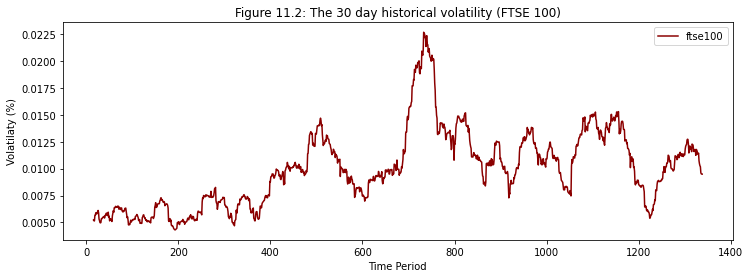

In [13]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (12,4)
# FTSE 100 Data
ftse_xs = range(len(vol_t["ftse100"]))
ftse_ys = vol_t["ftse100"]
plt.plot(ftse_xs, ftse_ys, '-', label="ftse100", color="darkred")

plt.title("Figure 11.2: The 30 day historical volatility (FTSE 100)")
plt.ylabel("Volatilaty (%)")
plt.xlabel("Time Period")
plt.legend()
plt.show()

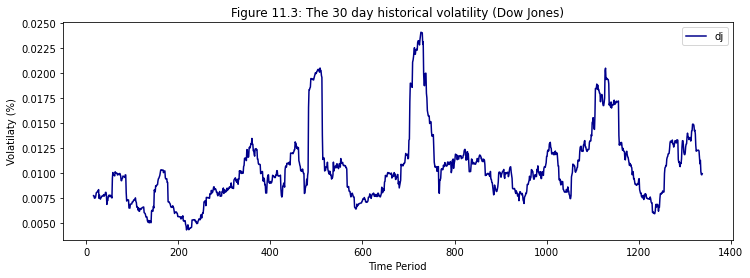

In [14]:
dj_xs = range(len(vol_t["dj"]))
dj_ys = vol_t["dj"]
plt.plot(dj_xs, dj_ys, '-', label="dj", color="darkblue")

plt.title("Figure 11.3: The 30 day historical volatility (Dow Jones)")
plt.ylabel("Volatilaty (%)")
plt.xlabel("Time Period")
plt.legend()
plt.show()

## Creation of Hand Crafted Features
$$[\frac{vol_{t-1}}{vol_{t-k}}] × vol_{t−1}, k = 1, 2, 3, 4, 5$$
换句话说，在时间t，我们使用昨天的波动率，通过它与最近过去值的比率调整。

In [15]:
x1 = np.log(vol_t.shift(1)/vol_t.shift(2)) * vol_t.shift(1)
x2 = np.log(vol_t.shift(1)/vol_t.shift(3)) * vol_t.shift(1)
x3 = np.log(vol_t.shift(1)/vol_t.shift(4)) * vol_t.shift(1)
x4 = np.log(vol_t.shift(1)/vol_t.shift(5)) * vol_t.shift(1)
x5 = np.log(vol_t.shift(1)/vol_t.shift(6)) * vol_t.shift(1)
data = pd.concat([vol_t, x1, x2, x3, x4, x5], axis=1)
data.columns = ['ftse_t', 'dj_t',
                'ftse_t_1', 'dj_t_1',
                'ftse_t_2', 'dj_t_2',
                'ftse_t_3', 'dj_t_3',
                'ftse_t_4', 'dj_t_4',
                'ftse_t_5', 'dj_t_5']
data = data.dropna()

## Target and Features in One Place

In [16]:
cols_y = ['ftse_t', 'dj_t']
y = data[cols_y]
cols_x = ['ftse_t_1', 'dj_t_1',
          'ftse_t_2', 'dj_t_2',
          'ftse_t_3', 'dj_t_3',
          'ftse_t_4', 'dj_t_4',
          'ftse_t_5', 'dj_t_5']
x = data[cols_x]

In [17]:
from sklearn import preprocessing
num_attrib = 10
scaler_x = preprocessing.MinMaxScaler(feature_range=(-1, 1))
x = np.array(x).reshape((len(x), num_attrib))
x = scaler_x.fit_transform(x)
    
num_response = 2
scaler_y = preprocessing.MinMaxScaler(feature_range=(0, 1))
y = np.array(y).reshape((len(y), num_response))
y = scaler_y.fit_transform(y)

In [19]:
train_end = 1131
data_end = len(data)  
x_train = x[0:train_end, ]
x_test = x[train_end:data_end, ]
y_train = y[0:train_end, ]
y_test =y[train_end:data_end, ]
x_train = np.reshape(x_train, (x_train.shape[0], 1, x_train.shape[1]))
x_test = np.reshape(x_test, (x_test.shape[0], 1, x_test.shape[1]))
print("shape of x_train is : %s" % str(x_train.shape))
print("shape of x_test is : %s" % str(x_test.shape))

shape of x_train is : (1131, 1, 10)
shape of x_test is : (186, 1, 10)


In [34]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.layers.recurrent import SimpleRNN
from keras.optimizers import SGD
seed = 2020
num_epochs = 10
np.random.seed(seed)
fit11 = Sequential()
fit11.add(SimpleRNN(
        units=10,
        activation='sigmoid',
        input_shape=(1,num_attrib)
))
fit11.add(Dense(
        units=num_response,
        activation='linear'
))
sgd = SGD(lr=0.1, momentum=0.9, nesterov=True)
fit11.compile(loss='mean_squared_error', optimizer=sgd)
fit11.fit(x_train, y_train, batch_size=1, epochs=num_epochs)

Epoch 1/10
1131/1131 [==============================] - 1s 1ms/step - loss: 0.0572
Epoch 2/10
1131/1131 [==============================] - 1s 1ms/step - loss: 0.0523
Epoch 3/10
1131/1131 [==============================] - 1s 1ms/step - loss: 0.0498
Epoch 4/10
1131/1131 [==============================] - 1s 1ms/step - loss: 0.0501
Epoch 5/10
1131/1131 [==============================] - 2s 1ms/step - loss: 0.0506
Epoch 6/10
1131/1131 [==============================] - 2s 2ms/step - loss: 0.0486
Epoch 7/10
1131/1131 [==============================] - 2s 2ms/step - loss: 0.0496
Epoch 8/10
1131/1131 [==============================] - 2s 2ms/step - loss: 0.0495
Epoch 9/10
1131/1131 [==============================] - 2s 2ms/step - loss: 0.0501
Epoch 10/10
1131/1131 [==============================] - 1s 1ms/step - loss: 0.0481


In [35]:
score_train = fit11.evaluate(x_train, y_train, batch_size=1)
score_test = fit11.evaluate(x_test, y_test, batch_size=1)
print("in train MSE = ", round(score_train, 5))
print("in test MSE = ", round(score_test, 5))

186/186 [==============================] - 0s 1ms/step - loss: 0.0192
in train MSE =  0.03732
in test MSE =  0.01924


In [36]:
forecast11 = fit11.predict(x_test)
forecast11 = scaler_y.inverse_transform(np.array(forecast11).reshape((len(forecast11), 2)))

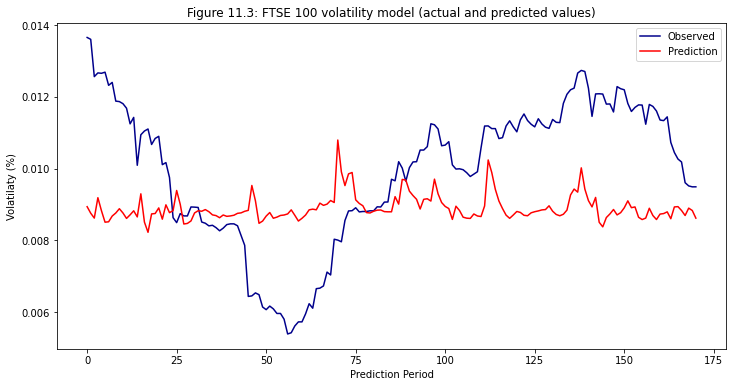

In [37]:
plt.rcParams['figure.figsize'] = (12,6)

# FIGURE 11.3 (p. 165)
# FTSE 100 Data
ftse_pred = forecast11[:, 0]

plt.plot(range(185), ftse_ys[-(185):], '-', label="Observed", color="darkblue")
plt.plot(range(185-14), ftse_pred.tolist()[-(185-14):], "-", label="Prediction", color="red")

plt.title("Figure 11.3: FTSE 100 volatility model (actual and predicted values)")
plt.ylabel("Volatilaty (%)")
plt.xlabel("Prediction Period")
plt.legend()
plt.show()

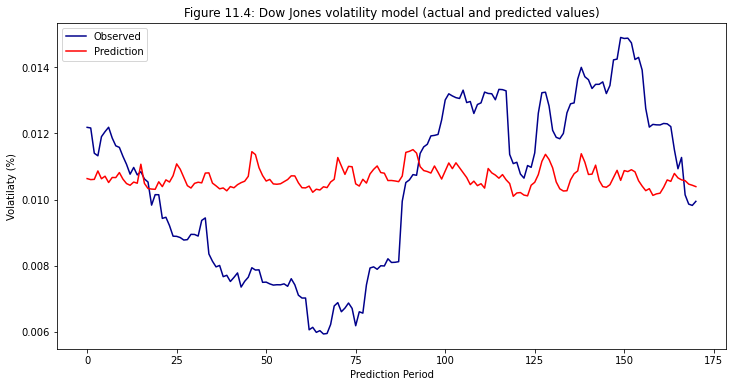

In [38]:
dj_pred = forecast11[:, 1]

plt.plot(range(185), dj_ys[-(185):], '-', label="Observed", color="darkblue")
plt.plot(range(185-14), dj_pred.tolist()[-(185-14):], "-", label="Prediction", color="red")

plt.title("Figure 11.4: Dow Jones volatility model (actual and predicted values)")
plt.ylabel("Volatilaty (%)")
plt.xlabel("Prediction Period")
plt.legend()
plt.show()